<a href="https://colab.research.google.com/github/Jothish2283/Variational_AutoEncoders/blob/main/variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**1.1. getting Data**

In [1]:
!pip -q install torch_snippets
!pip -q install torchinfo
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torchinfo
from torch_snippets import*
import matplotlib.pyplot as plt

#device agniostic code:
device= "cuda" if torch.cuda.is_available() else "cpu"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.9/172.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 77.4 MB/s eta 0:00:

In [2]:
device

'cuda'

In [3]:
trn_dataset=datasets.MNIST(root="MNIST/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset=datasets.MNIST(root="MNIST/", train=False, transform=transforms.ToTensor(), download=True)

trn_dl=torch.utils.data.DataLoader(trn_dataset, batch_size=32, shuffle=True)
test_dl=torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 95104106.61it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35040698.24it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28466315.69it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24175797.93it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



##**1.2. Building the model**

In [4]:
class VAE(nn.Module):
  def __init__(self, in_dim, h_dim1, h_dim2, dist_dim): #dist->distribution[sigma & mu] h->hidden
    super().__init__()
    self.d1=nn.Linear(in_dim, h_dim1)
    self.d2=nn.Linear(h_dim1, h_dim2)
    self.d31=nn.Linear(h_dim2, dist_dim)
    self.d32=nn.Linear(h_dim2, dist_dim)
    self.d4=nn.Linear(dist_dim, h_dim2)
    self.d5=nn.Linear(h_dim2, h_dim1)
    self.d6=nn.Linear(h_dim1, in_dim)

  def encoder(self, x):
    pre_distribution= F.relu(self.d2(F.relu(self.d1(x))))

    return self.d31(pre_distribution), self.d32(pre_distribution) #we assume that d32 returns log_var

  def sampling(self, mean, log_var):
    std=torch.exp(0.5*log_var)
    eps=torch.randn_like(std)
    return torch.add(torch.mul(std, eps), mean)

  def decoder(self, dist):
    post_distribution=nn.Sequential(self.d4, nn.ReLU(),
                                    self.d5, nn.ReLU(),
                                    self.d6, nn.Sigmoid()) #pixel value ranges from 0-1
    return post_distribution(dist)

  def forward(self, x):
    mean, log_var= self.encoder(x.view(-1, 784)) #img size= [28*28]
    z=self.sampling(mean, log_var)
    return self.decoder(z), mean, log_var

In [5]:
model= VAE(in_dim=784, h_dim1=512, h_dim2=256, dist_dim=64).to(device)
torchinfo.summary(model, input_size=(32,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 784]                 --
├─Linear: 1-1                            [32, 512]                 401,920
├─Linear: 1-2                            [32, 256]                 131,328
├─Linear: 1-3                            [32, 64]                  16,448
├─Linear: 1-4                            [32, 64]                  16,448
├─Linear: 1-5                            [32, 256]                 16,640
├─Linear: 1-6                            [32, 512]                 131,584
├─Linear: 1-7                            [32, 784]                 402,192
Total params: 1,116,560
Trainable params: 1,116,560
Non-trainable params: 0
Total mult-adds (M): 35.73
Input size (MB): 0.10
Forward/backward pass size (MB): 0.63
Params size (MB): 4.47
Estimated Total Size (MB): 5.19

##**1.3. Running the model**

In [6]:
def loss_function(recon_x, x, mean, log_var):
  recon=F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
  kld=-0.5*torch.sum(1+log_var-mean.pow(2)-log_var.exp())
  return recon+kld, recon, kld

In [7]:
def train_epoch(model, input, criterion, optimizer):
  model.train()
  output, mean, log_var=model(input)
  loss, mse, kld=criterion(output, input, mean, log_var)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss, mse, kld, mean.mean(), log_var.mean()

def val_epoch(model, input, criterion):
  model.eval()
  with torch.inference_mode():
    output, mean, log_var=model(input)
    loss, mse, kld=criterion(output, input, mean, log_var)
    return loss, mse, kld, mean.mean(), log_var.mean()

In [8]:
EPOCHS=100
optimizer=torch.optim.AdamW(model.parameters())

EPOCH: 1.000  train_loss: 932.942  val_logvar: -0.312  val_mean: -0.006  val_mse: 611.011  val_loss: 931.259  train_mean: 0.000  train_kld: 314.347  train_logvar: -0.308  val_kld: 320.249  train_mse: 618.595  (15.24s - 1508.38s remaining)
EPOCH: 2.000  train_loss: 930.154  val_logvar: -0.307  val_mean: -0.006  val_mse: 612.248  val_loss: 926.736  train_mean: 0.000  train_kld: 316.309  train_logvar: -0.310  val_kld: 314.488  train_mse: 613.845  (31.49s - 1542.87s remaining)
EPOCH: 3.000  train_loss: 926.859  val_logvar: -0.317  val_mean: -0.005  val_mse: 602.462  val_loss: 924.449  train_mean: 0.000  train_kld: 317.131  train_logvar: -0.310  val_kld: 321.986  train_mse: 609.728  (47.35s - 1530.95s remaining)
EPOCH: 4.000  train_loss: 924.683  val_logvar: -0.310  val_mean: -0.003  val_mse: 607.172  val_loss: 924.623  train_mean: 0.000  train_kld: 318.023  train_logvar: -0.311  val_kld: 317.451  train_mse: 606.661  (62.73s - 1505.63s remaining)
EPOCH: 5.000  train_loss: 921.505  val_logva

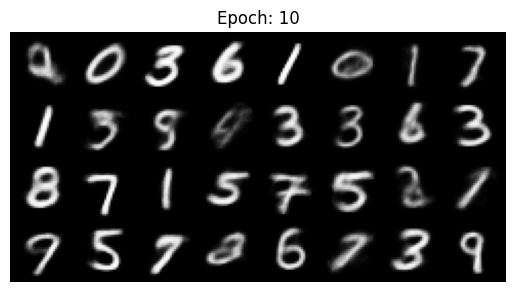

EPOCH: 10.000  train_loss: 912.474  val_logvar: -0.305  val_mean: -0.002  val_mse: 604.385  val_loss: 918.660  train_mean: 0.000  train_kld: 322.486  train_logvar: -0.316  val_kld: 314.274  train_mse: 589.987  (156.89s - 1412.00s remaining)
EPOCH: 11.000  train_loss: 911.652  val_logvar: -0.319  val_mean: -0.002  val_mse: 592.444  val_loss: 915.805  train_mean: -0.000  train_kld: 323.229  train_logvar: -0.316  val_kld: 323.361  train_mse: 588.423  (172.64s - 1396.81s remaining)
EPOCH: 12.000  train_loss: 909.360  val_logvar: -0.317  val_mean: -0.005  val_mse: 587.339  val_loss: 910.601  train_mean: 0.000  train_kld: 323.337  train_logvar: -0.317  val_kld: 323.262  train_mse: 586.024  (187.90s - 1377.90s remaining)
EPOCH: 13.000  train_loss: 909.782  val_logvar: -0.318  val_mean: -0.003  val_mse: 586.510  val_loss: 914.512  train_mean: 0.000  train_kld: 324.570  train_logvar: -0.318  val_kld: 328.002  train_mse: 585.212  (203.03s - 1358.76s remaining)
EPOCH: 14.000  train_loss: 907.905 

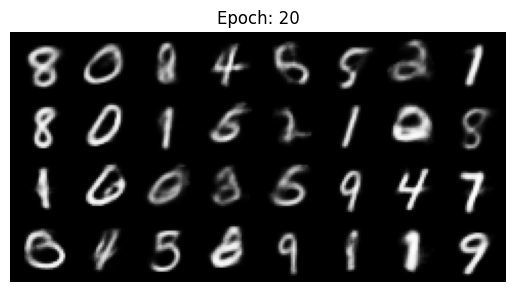

EPOCH: 20.000  train_loss: 902.842  val_logvar: -0.322  val_mean: -0.002  val_mse: 587.809  val_loss: 913.738  train_mean: -0.000  train_kld: 326.806  train_logvar: -0.320  val_kld: 325.929  train_mse: 576.037  (324.37s - 1297.47s remaining)
EPOCH: 21.000  train_loss: 902.299  val_logvar: -0.318  val_mean: -0.006  val_mse: 584.226  val_loss: 907.868  train_mean: 0.000  train_kld: 327.203  train_logvar: -0.320  val_kld: 323.642  train_mse: 575.096  (340.34s - 1280.32s remaining)
EPOCH: 22.000  train_loss: 901.452  val_logvar: -0.327  val_mean: -0.006  val_mse: 578.756  val_loss: 906.854  train_mean: 0.000  train_kld: 327.782  train_logvar: -0.321  val_kld: 328.098  train_mse: 573.670  (356.14s - 1262.70s remaining)
EPOCH: 23.000  train_loss: 900.636  val_logvar: -0.325  val_mean: -0.007  val_mse: 579.336  val_loss: 910.833  train_mean: 0.000  train_kld: 327.729  train_logvar: -0.321  val_kld: 331.497  train_mse: 572.908  (374.69s - 1254.40s remaining)
EPOCH: 24.000  train_loss: 899.789 

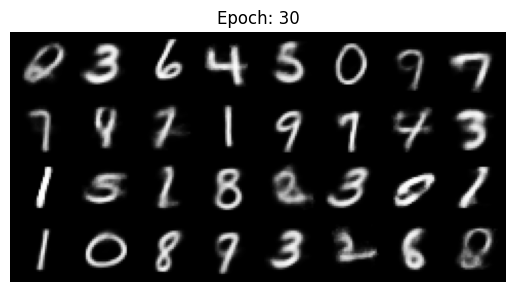

EPOCH: 30.000  train_loss: 897.121  val_logvar: -0.322  val_mean: -0.006  val_mse: 578.087  val_loss: 906.241  train_mean: -0.000  train_kld: 329.605  train_logvar: -0.323  val_kld: 328.153  train_mse: 567.516  (490.89s - 1145.40s remaining)
EPOCH: 31.000  train_loss: 895.856  val_logvar: -0.316  val_mean: -0.004  val_mse: 571.667  val_loss: 900.415  train_mean: 0.000  train_kld: 329.958  train_logvar: -0.323  val_kld: 328.748  train_mse: 565.898  (507.25s - 1129.03s remaining)
EPOCH: 32.000  train_loss: 894.540  val_logvar: -0.317  val_mean: -0.002  val_mse: 579.708  val_loss: 906.538  train_mean: 0.000  train_kld: 329.145  train_logvar: -0.322  val_kld: 326.831  train_mse: 565.395  (523.03s - 1111.44s remaining)
EPOCH: 33.000  train_loss: 895.967  val_logvar: -0.330  val_mean: -0.005  val_mse: 560.971  val_loss: 898.842  train_mean: 0.000  train_kld: 329.801  train_logvar: -0.323  val_kld: 337.872  train_mse: 566.166  (539.24s - 1094.82s remaining)
EPOCH: 34.000  train_loss: 894.765 

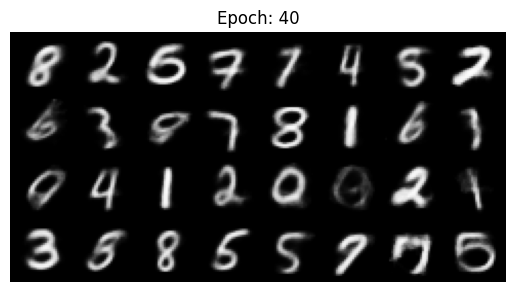

EPOCH: 40.000  train_loss: 892.285  val_logvar: -0.322  val_mean: -0.001  val_mse: 572.619  val_loss: 901.314  train_mean: 0.000  train_kld: 330.899  train_logvar: -0.324  val_kld: 328.695  train_mse: 561.387  (649.10s - 973.65s remaining)
EPOCH: 41.000  train_loss: 891.477  val_logvar: -0.332  val_mean: 0.003  val_mse: 570.465  val_loss: 905.378  train_mean: 0.000  train_kld: 331.279  train_logvar: -0.324  val_kld: 334.912  train_mse: 560.198  (665.30s - 957.38s remaining)
EPOCH: 42.000  train_loss: 891.776  val_logvar: -0.318  val_mean: 0.002  val_mse: 572.768  val_loss: 901.558  train_mean: 0.000  train_kld: 331.407  train_logvar: -0.324  val_kld: 328.790  train_mse: 560.370  (680.77s - 940.11s remaining)
EPOCH: 43.000  train_loss: 891.972  val_logvar: -0.324  val_mean: -0.005  val_mse: 565.681  val_loss: 902.006  train_mean: 0.000  train_kld: 331.342  train_logvar: -0.324  val_kld: 336.324  train_mse: 560.630  (696.33s - 923.05s remaining)
EPOCH: 44.000  train_loss: 890.942  val_lo

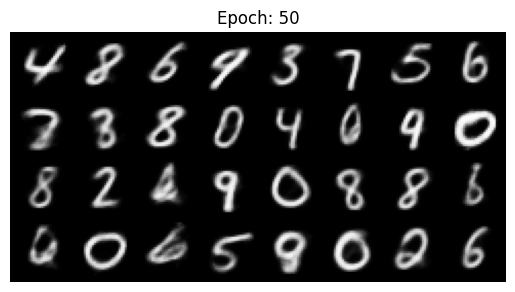

EPOCH: 50.000  train_loss: 888.453  val_logvar: -0.334  val_mean: -0.007  val_mse: 566.309  val_loss: 902.089  train_mean: -0.000  train_kld: 331.681  train_logvar: -0.324  val_kld: 335.779  train_mse: 556.772  (806.17s - 806.17s remaining)
EPOCH: 51.000  train_loss: 889.217  val_logvar: -0.322  val_mean: -0.001  val_mse: 573.377  val_loss: 896.842  train_mean: 0.000  train_kld: 332.572  train_logvar: -0.325  val_kld: 323.465  train_mse: 556.645  (821.72s - 789.50s remaining)
EPOCH: 52.000  train_loss: 888.337  val_logvar: -0.328  val_mean: -0.004  val_mse: 561.857  val_loss: 896.267  train_mean: -0.000  train_kld: 331.967  train_logvar: -0.325  val_kld: 334.410  train_mse: 556.369  (837.32s - 772.91s remaining)
EPOCH: 53.000  train_loss: 888.038  val_logvar: -0.322  val_mean: -0.004  val_mse: 568.850  val_loss: 896.875  train_mean: 0.000  train_kld: 332.113  train_logvar: -0.325  val_kld: 328.025  train_mse: 555.926  (854.26s - 757.56s remaining)
EPOCH: 54.000  train_loss: 888.218  va

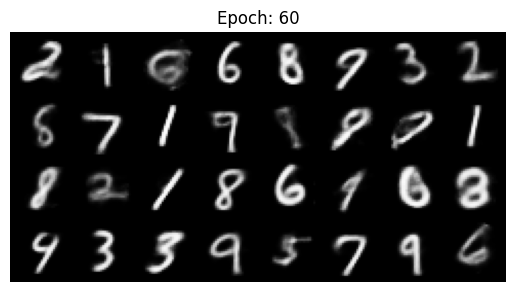

EPOCH: 60.000  train_loss: 886.866  val_logvar: -0.340  val_mean: -0.003  val_mse: 563.397  val_loss: 906.056  train_mean: -0.000  train_kld: 333.525  train_logvar: -0.326  val_kld: 342.659  train_mse: 553.341  (964.32s - 642.88s remaining)
EPOCH: 61.000  train_loss: 886.869  val_logvar: -0.317  val_mean: -0.003  val_mse: 571.742  val_loss: 895.492  train_mean: 0.000  train_kld: 333.773  train_logvar: -0.326  val_kld: 323.750  train_mse: 553.096  (980.38s - 626.80s remaining)
EPOCH: 62.000  train_loss: 886.159  val_logvar: -0.330  val_mean: -0.002  val_mse: 563.687  val_loss: 899.944  train_mean: 0.000  train_kld: 332.874  train_logvar: -0.326  val_kld: 336.257  train_mse: 553.285  (995.80s - 610.33s remaining)
EPOCH: 63.000  train_loss: 885.546  val_logvar: -0.329  val_mean: -0.001  val_mse: 565.901  val_loss: 898.892  train_mean: -0.000  train_kld: 332.960  train_logvar: -0.326  val_kld: 332.991  train_mse: 552.586  (1011.31s - 593.94s remaining)
EPOCH: 64.000  train_loss: 885.735  v

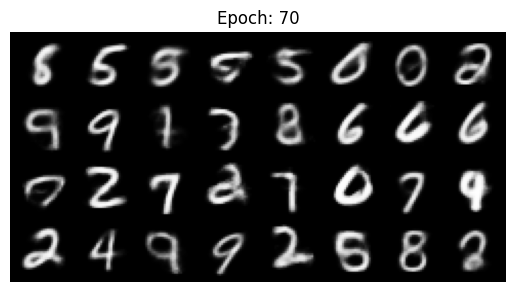

EPOCH: 70.000  train_loss: 884.370  val_logvar: -0.329  val_mean: -0.002  val_mse: 556.491  val_loss: 896.682  train_mean: 0.000  train_kld: 333.738  train_logvar: -0.326  val_kld: 340.191  train_mse: 550.632  (1122.13s - 480.91s remaining)
EPOCH: 71.000  train_loss: 884.326  val_logvar: -0.327  val_mean: 0.000  val_mse: 564.624  val_loss: 897.216  train_mean: 0.000  train_kld: 333.618  train_logvar: -0.326  val_kld: 332.592  train_mse: 550.708  (1137.68s - 464.68s remaining)
EPOCH: 72.000  train_loss: 885.203  val_logvar: -0.333  val_mean: -0.003  val_mse: 557.644  val_loss: 894.266  train_mean: 0.000  train_kld: 333.893  train_logvar: -0.326  val_kld: 336.622  train_mse: 551.310  (1153.69s - 448.66s remaining)
EPOCH: 73.000  train_loss: 884.234  val_logvar: -0.321  val_mean: -0.003  val_mse: 568.875  val_loss: 898.162  train_mean: 0.000  train_kld: 334.076  train_logvar: -0.327  val_kld: 329.286  train_mse: 550.158  (1169.64s - 432.61s remaining)
EPOCH: 74.000  train_loss: 884.588  v

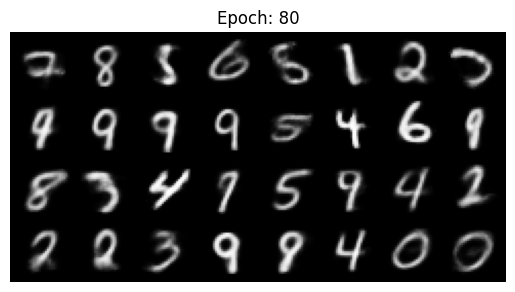

EPOCH: 80.000  train_loss: 882.937  val_logvar: -0.332  val_mean: -0.005  val_mse: 559.317  val_loss: 895.798  train_mean: -0.000  train_kld: 334.223  train_logvar: -0.326  val_kld: 336.481  train_mse: 548.714  (1280.80s - 320.20s remaining)
EPOCH: 81.000  train_loss: 882.849  val_logvar: -0.331  val_mean: -0.002  val_mse: 557.674  val_loss: 893.214  train_mean: 0.000  train_kld: 334.328  train_logvar: -0.327  val_kld: 335.540  train_mse: 548.521  (1296.53s - 304.12s remaining)
EPOCH: 82.000  train_loss: 882.825  val_logvar: -0.322  val_mean: -0.009  val_mse: 568.372  val_loss: 897.293  train_mean: -0.000  train_kld: 334.539  train_logvar: -0.327  val_kld: 328.922  train_mse: 548.286  (1312.17s - 288.04s remaining)
EPOCH: 83.000  train_loss: 883.521  val_logvar: -0.320  val_mean: 0.000  val_mse: 567.649  val_loss: 899.526  train_mean: 0.000  train_kld: 334.889  train_logvar: -0.327  val_kld: 331.877  train_mse: 548.632  (1327.74s - 271.95s remaining)
EPOCH: 84.000  train_loss: 882.971 

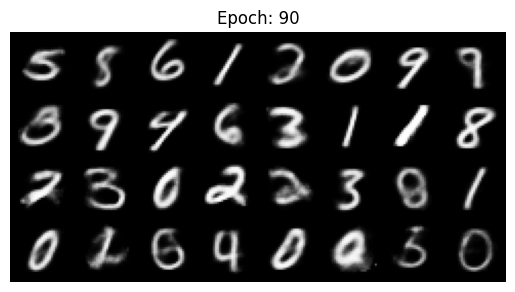

EPOCH: 90.000  train_loss: 881.594  val_logvar: -0.324  val_mean: -0.004  val_mse: 561.302  val_loss: 892.207  train_mean: 0.000  train_kld: 333.819  train_logvar: -0.326  val_kld: 330.905  train_mse: 547.775  (1439.40s - 159.93s remaining)
EPOCH: 91.000  train_loss: 882.360  val_logvar: -0.330  val_mean: -0.000  val_mse: 553.479  val_loss: 894.036  train_mean: -0.000  train_kld: 335.100  train_logvar: -0.327  val_kld: 340.558  train_mse: 547.260  (1455.11s - 143.91s remaining)
EPOCH: 92.000  train_loss: 882.256  val_logvar: -0.324  val_mean: -0.006  val_mse: 561.962  val_loss: 895.312  train_mean: 0.000  train_kld: 334.798  train_logvar: -0.327  val_kld: 333.351  train_mse: 547.458  (1471.38s - 127.95s remaining)
EPOCH: 93.000  train_loss: 881.728  val_logvar: -0.325  val_mean: -0.000  val_mse: 563.506  val_loss: 893.525  train_mean: 0.000  train_kld: 334.838  train_logvar: -0.327  val_kld: 330.019  train_mse: 546.890  (1487.03s - 111.93s remaining)
EPOCH: 94.000  train_loss: 881.235 

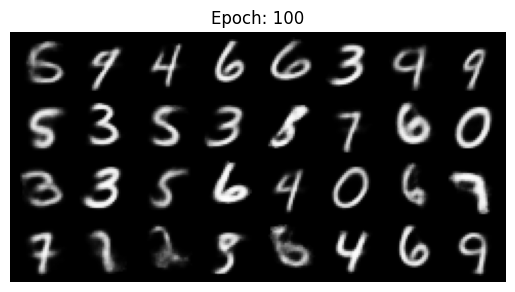

EPOCH: 100.000  train_loss: 880.192  val_logvar: -0.327  val_mean: -0.006  val_mse: 561.262  val_loss: 892.857  train_mean: 0.000  train_kld: 334.803  train_logvar: -0.327  val_kld: 331.595  train_mse: 545.389  (1598.78s - 0.00s remaining)


In [12]:
log= Report(EPOCHS)
for epoch in range(EPOCHS):
  n=len(trn_dl)
  for ix, (input, _) in enumerate(trn_dl):
    loss, mse, kld, mean, log_var=train_epoch(model, input.to(device), criterion=loss_function, optimizer=optimizer)
    log.record(epoch+(ix+1)/n, train_loss=loss, train_mse=mse, train_kld=kld, train_mean=mean, train_logvar= log_var, end="\r")
  n=len(test_dl)
  for ix, (input, _) in enumerate(test_dl):
    loss, mse, kld, mean, log_var=val_epoch(model, input.to(device), criterion=loss_function)
    log.record(epoch+(ix+1)/n, val_loss=loss, val_mse=mse, val_kld=kld, val_mean=mean, val_logvar= log_var, end="\r")

  log.report_avgs(epoch+1)

  if (epoch+1)%10==0:
    model.eval()
    with torch.inference_mode():
      random_vec= torch.randn((32, 64))
      im= model.decoder(random_vec.to(device))
      grid= torchvision.utils.make_grid(im.cpu().view(32, 1, 28, 28))
      plt.imshow(grid.permute(1,2,0));
      plt.title(f"Epoch: {epoch+1}");
      plt.axis("off");
      plt.show();

100%|██████████| 201/201 [00:11<00:00, 17.47it/s]


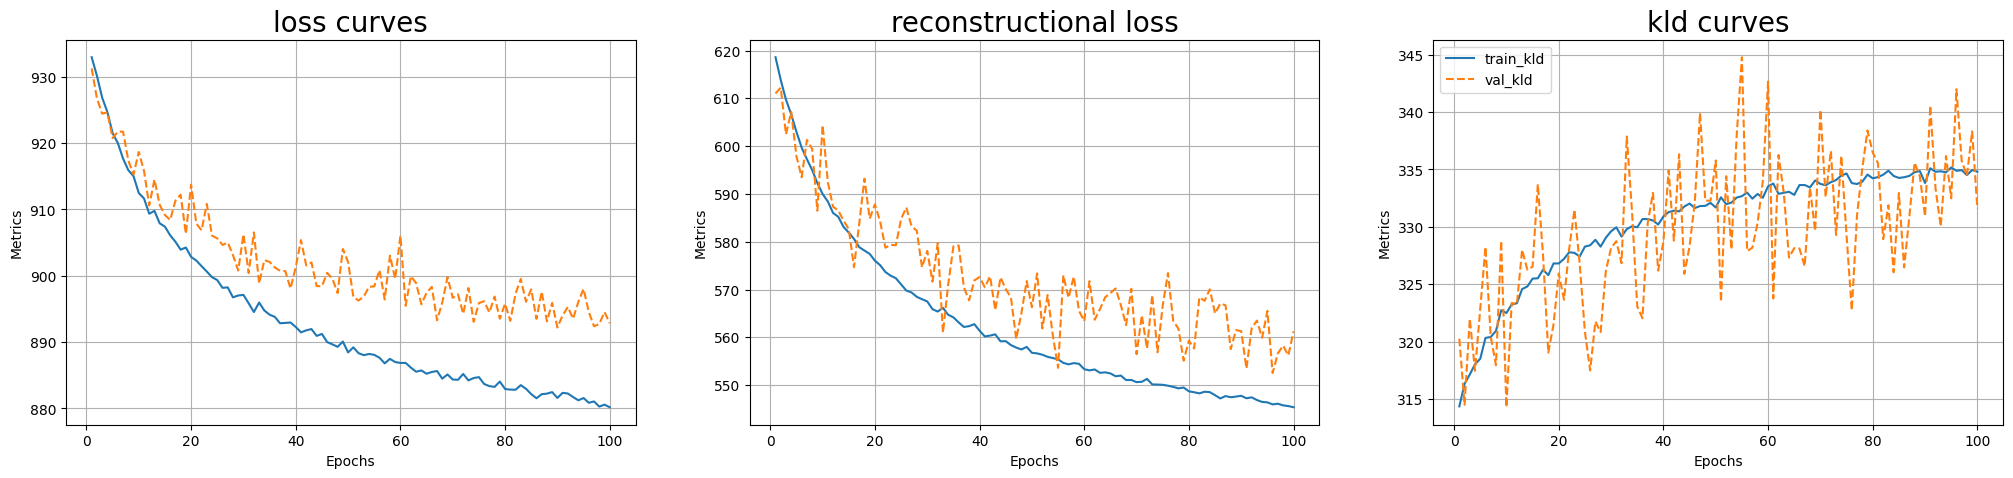

In [20]:
fig, ax= plt.subplots(ncols=3, figsize=(25, 5))
log.plot_epochs(["train_loss", "val_loss"], ax=ax[0], title="loss curves")
log.plot_epochs(["train_mse", "val_mse"], ax=ax[1], title="reconstructional loss")
log.plot_epochs(["train_kld", "val_kld"], ax=ax[2], title="kld curves")

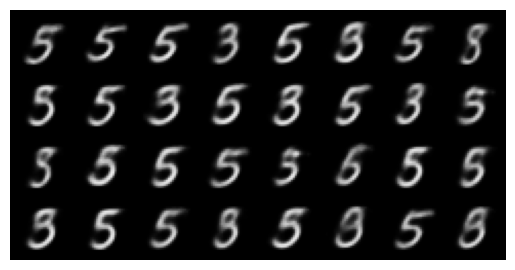

In [22]:
model.eval()
with torch.inference_mode():
  random_vec= torch.rand((32, 64)) #randn and rand both produce meaningful results
  im= model.decoder(random_vec.to(device))
  grid= torchvision.utils.make_grid(im.cpu().view(32, 1, 28, 28))
  plt.imshow(grid.permute(1,2,0));
  plt.axis("off");
  plt.show();